# EDA for IPL Dataset
**Arham Aneeq / 240005009**
This Notebook presents broad steps used to perform exploratory Data Analysis (EDA) of the IPL Auction Dataset. The Notebook underlines the steps taken to clean and manipulate the raw data, as well as the basic analysis performed on the Dataset. It further includes simple Machine Learning models applied to the dataset to classify or predict certain features in terms of others. The Analysis uncovers underlying patterns in trends, with respect to indidual trades, players, and teams. 

## Tools & Libraries Used

In [1]:
# IMPORTS
# Data Manipulation
import pandas as pd

# Visualisation

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics

import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

# Classification & Regression
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# SETUP
sns.set_theme(style='darkgrid', palette='dark')

## Cleaning

### Initial Dataframe

In [2]:
# Load Data
df = pd.read_csv("final_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1052 non-null   int64  
 1   Country      1052 non-null   object 
 2   Player       1052 non-null   object 
 3   Team         1052 non-null   object 
 4   Base price   1052 non-null   float64
 5   Winning bid  1052 non-null   object 
 6   Year         1052 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 57.7+ KB


In [4]:
df.nunique()

Unnamed: 0     1052
Country          29
Player          593
Team             17
Base price       15
Winning bid     128
Year             11
dtype: int64

### Cleaning Steps

In [5]:
# Drop Empty Columns
df = df.drop(df.columns[df.columns.str.contains('Unnamed', case=False)], axis=1)

In [6]:
# Strip nonumeric characters form the 'Winning bid' column, and recast data type to float
df['Winning bid'] = df['Winning bid'].str.extract(r'(\d+\.?\d*)').astype(float)

In [7]:
# Strip Extra Whitespaces from 
df['Country'] = df['Country'].str.extract(r'^\s*(.*?)\s*$')

In [8]:
# Define a New Change (Delta) Column
df['Change'] = df['Winning bid'] - df['Base price']
# Remove Elements with Negative Change
df = df[df['Change'] >= 0]

In [9]:
# Fix typos in the 'Team' column
for row in df.index:
    if df.loc[row, 'Team'] == 'Delhi Dardevils':
        df.loc[row, 'Team'] = 'Delhi Daredevils'
    if df.loc[row, 'Team'] == 'Delhi Daredevils':
        df.loc[row, 'Team'] = 'Delhi Capitals'
    if df.loc[row, 'Team'] == 'Rising Pune Supergiants':
        df.loc[row, 'Team'] = 'Rising Pune Supergiant'
    if df.loc[row, 'Team'] == 'Rising Pune Supergiant':
        df.loc[row, 'Team'] = 'Lucknow Super Giants'
    if df.loc[row, 'Team'] == 'Kings XI Punjab':
        df.loc[row, 'Team'] = 'Punjab Kings'

In [10]:
# Club West Indies Teams
for row in df.index:
    if df.loc[row, 'Country'] in {"Namibia", 'Trinidad and Tobago', 'Jamaica', 'Barbados', 'Guyana'}:
        df.loc[row, 'Country'] = 'West Indies'

In [11]:
# Drop Players Accounted for by Multiple Countries
df = df[~df['Player'].isin((lambda v: v[v > 1].index)(df.groupby('Player')['Country'].nunique()))].sort_values(['Player'])

In [12]:
# Drop Duplicate Columns
df = df.drop_duplicates()

In [13]:
# Reset Indices
df.reset_index(drop=True, inplace=True)

### Cleaned Dataframe

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      1038 non-null   object 
 1   Player       1038 non-null   object 
 2   Team         1038 non-null   object 
 3   Base price   1038 non-null   float64
 4   Winning bid  1038 non-null   float64
 5   Year         1038 non-null   int64  
 6   Change       1038 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 56.9+ KB


In [15]:
df.nunique()

Country         15
Player         589
Team            12
Base price      15
Winning bid    121
Year            11
Change         138
dtype: int64

### Derived Tables

In [16]:
# Data Aggregated by Player
player_df = df.groupby('Player').agg(
    Num_of_Teams=('Team', 'nunique'),
    Base_Price_High=('Base price', 'max'),
    Base_Price_Low=('Base price', 'min'),
    Winning_Bid_High = ('Winning bid', 'max'),
    Winning_Bid_Mean = ('Winning bid', 'mean'),
    Winning_Bid_Low = ('Winning bid', 'max'),
    Largest_Delta = ('Change', 'max'),
    Smallest_Delta = ('Change', 'min'),
    Mean_Delta = ('Change', 'mean'),
    Country = ('Country', 'first'),
    Year_Range = ('Year', lambda year: year.max() - year.min()),
    Avg_Trade_Gap = ('Year', lambda year: np.mean(gaps) if len((gaps := np.diff(sorted(year.unique())))) > 0 else year.max() - year.min())
).reset_index()
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            589 non-null    object 
 1   Num_of_Teams      589 non-null    int64  
 2   Base_Price_High   589 non-null    float64
 3   Base_Price_Low    589 non-null    float64
 4   Winning_Bid_High  589 non-null    float64
 5   Winning_Bid_Mean  589 non-null    float64
 6   Winning_Bid_Low   589 non-null    float64
 7   Largest_Delta     589 non-null    float64
 8   Smallest_Delta    589 non-null    float64
 9   Mean_Delta        589 non-null    float64
 10  Country           589 non-null    object 
 11  Year_Range        589 non-null    int64  
 12  Avg_Trade_Gap     589 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 59.9+ KB


In [17]:
# Data Aggregated by Team
team_df = df.groupby('Team').agg(
    Num_of_Players = ('Player', 'nunique'),
    Winning_Bid_High = ('Winning bid', 'max'),
    Winning_Bid_Mean = ('Winning bid', 'mean'),
    Winning_Bid_Low = ('Winning bid', 'min'),
    Largest_Delta = ('Change', 'max'),
    Mean_Delta = ('Change', 'mean'),
).reset_index()
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Team              12 non-null     object 
 1   Num_of_Players    12 non-null     int64  
 2   Winning_Bid_High  12 non-null     float64
 3   Winning_Bid_Mean  12 non-null     float64
 4   Winning_Bid_Low   12 non-null     float64
 5   Largest_Delta     12 non-null     float64
 6   Mean_Delta        12 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 804.0+ bytes


In [18]:
# Data Aggregated by Year
yearly_df = df.groupby("Year").agg(
    Num_of_Auctioned_Players = ('Player', 'nunique'),
    Num_of_Bidding_Teams = ('Team', 'nunique'),
    Winning_High = ('Winning bid', 'max'),
    Winning_Mean = ('Winning bid', 'mean'),
    Winning_Low = ('Winning bid', 'min'),
    Base_High = ('Base price', 'max'),
    Base_Low = ('Base price', 'min'),
    Delta_High = ('Change', 'max'),
    Delta_Mean = ('Change', 'mean'),
    Total_Traded_Volume = ('Winning bid', 'sum'),
).reset_index()

yearly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      11 non-null     int64  
 1   Num_of_Auctioned_Players  11 non-null     int64  
 2   Num_of_Bidding_Teams      11 non-null     int64  
 3   Winning_High              11 non-null     float64
 4   Winning_Mean              11 non-null     float64
 5   Winning_Low               11 non-null     float64
 6   Base_High                 11 non-null     float64
 7   Base_Low                  11 non-null     float64
 8   Delta_High                11 non-null     float64
 9   Delta_Mean                11 non-null     float64
 10  Total_Traded_Volume       11 non-null     float64
dtypes: float64(8), int64(3)
memory usage: 1.1 KB


## Analysis

### Univariate Analysis

#### Table Description

In [19]:
df.describe()

,Base price,Winning bid,Year,Change
count,1038.000000,1038.000000,1038.000000,1038.000000
mean,64.215029,199.768642,2018.284200,135.553613
std,62.567094,268.754084,3.139195,237.862211
min,10.000000,10.000000,2013.000000,0.000000
25%,20.000000,20.000000,2016.000000,0.000000
50%,30.000000,80.000000,2018.000000,2.500000
75%,100.000000,260.000000,2022.000000,180.000000
max,244.000000,1625.000000,2023.000000,1550.000000


In [20]:
team_df.describe()

,Num_of_Players,Winning_Bid_High,Winning_Bid_Mean,Winning_Bid_Low,Largest_Delta,Mean_Delta
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,78.166667,1249.354167,208.672037,30.333333,1121.812500,142.451291
std,39.514861,430.243595,69.568098,67.348933,385.053555,56.958546
min,4.000000,400.000000,82.333333,10.000000,390.000000,42.333333
25%,47.000000,1075.000000,186.248931,10.000000,965.000000,118.969371
50%,98.000000,1425.000000,198.556657,10.000000,1250.000000,135.704839
75%,108.750000,1531.250000,225.794318,10.000000,1381.250000,155.891387
max,119.000000,1625.000000,381.250000,244.000000,1550.000000,282.125000


In [21]:
player_df.describe()

,Num_of_Teams,Base_Price_High,Base_Price_Low,Winning_Bid_High,Winning_Bid_Mean,Winning_Bid_Low,Largest_Delta,Smallest_Delta,Mean_Delta,Year_Range,Avg_Trade_Gap
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.00000,589.000000
mean,1.592530,67.404414,45.835654,233.089643,159.569941,233.089643,170.562988,49.412903,103.377587,1.86927,1.128315
std,0.914925,66.583839,50.501098,313.068321,196.718989,313.068321,279.204603,127.228411,169.085454,2.69824,1.587659
min,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.000000,30.000000,20.000000,85.000000,75.000000,85.000000,20.000000,0.000000,11.666667,0.00000,0.000000
75%,2.000000,100.000000,50.000000,320.000000,229.812500,320.000000,250.000000,25.000000,150.000000,4.00000,2.000000
max,6.000000,244.000000,244.000000,1625.000000,1350.000000,1625.000000,1550.000000,1050.000000,1150.000000,10.00000,8.000000


In [22]:
yearly_df.describe()

,Year,Num_of_Auctioned_Players,Num_of_Bidding_Teams,Winning_High,Winning_Mean,Winning_Low,Base_High,Base_Low,Delta_High,Delta_Mean,Total_Traded_Volume
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2018.000000,94.272727,8.454545,1193.181818,187.756456,15.654545,204.000000,15.654545,1048.000000,127.192125,18850.895455
std,3.316625,54.247748,0.820200,374.708371,55.097970,5.031176,13.266499,5.031176,354.661811,45.350394,15575.692027
min,2013.000000,37.000000,8.000000,610.000000,115.270270,10.000000,200.000000,10.000000,488.000000,62.162162,7249.850000
25%,2015.500000,61.000000,8.000000,870.000000,143.361541,10.000000,200.000000,10.000000,772.500000,90.729665,8822.500000
50%,2018.000000,66.000000,8.000000,1250.000000,178.000000,20.000000,200.000000,20.000000,1050.000000,123.583333,13970.000000
75%,2020.500000,122.500000,8.500000,1537.500000,239.484447,20.000000,200.000000,20.000000,1362.500000,165.533794,19220.000000
max,2023.000000,203.000000,10.000000,1625.000000,268.201970,20.000000,244.000000,20.000000,1550.000000,194.507389,54445.000000


#### Graphs

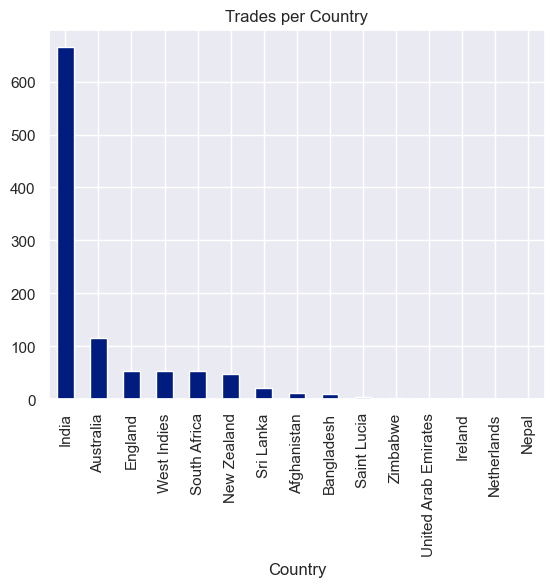

In [23]:
# Trades per Player Nationality
df['Country'].value_counts().plot(kind="bar")
plt.title("Trades per Country")
plt.show()

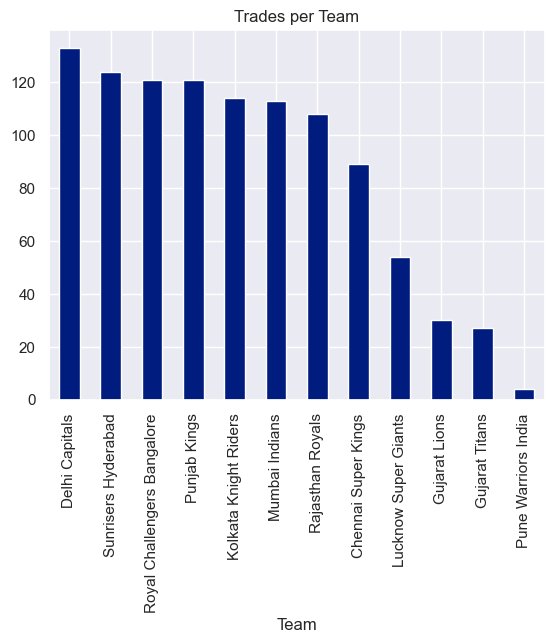

In [24]:
# Trades per Team bar Chart
df['Team'].value_counts().plot(kind="bar")
plt.title("Trades per Team")
plt.show()

### Multivariate Analysis

#### Correlation Analysis

In [25]:
# Correlation Matrix
corr_player = player_df.select_dtypes(include="number").corr()
corr_team = team_df.select_dtypes(include="number").corr()
corr_yearly = yearly_df.select_dtypes(include="number").corr()

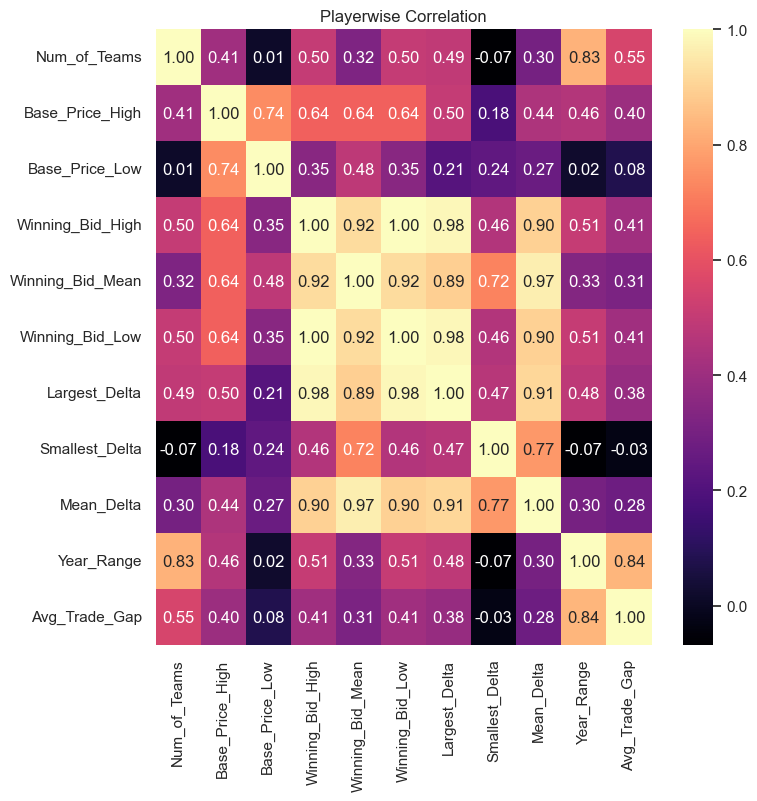

In [26]:
# Correlation Matrix for 'player_df'
plt.figure(figsize=(8,8))
sns.heatmap(corr_player, annot=True, cmap='magma', fmt='.2f')
plt.title('Playerwise Correlation')

plt.show();

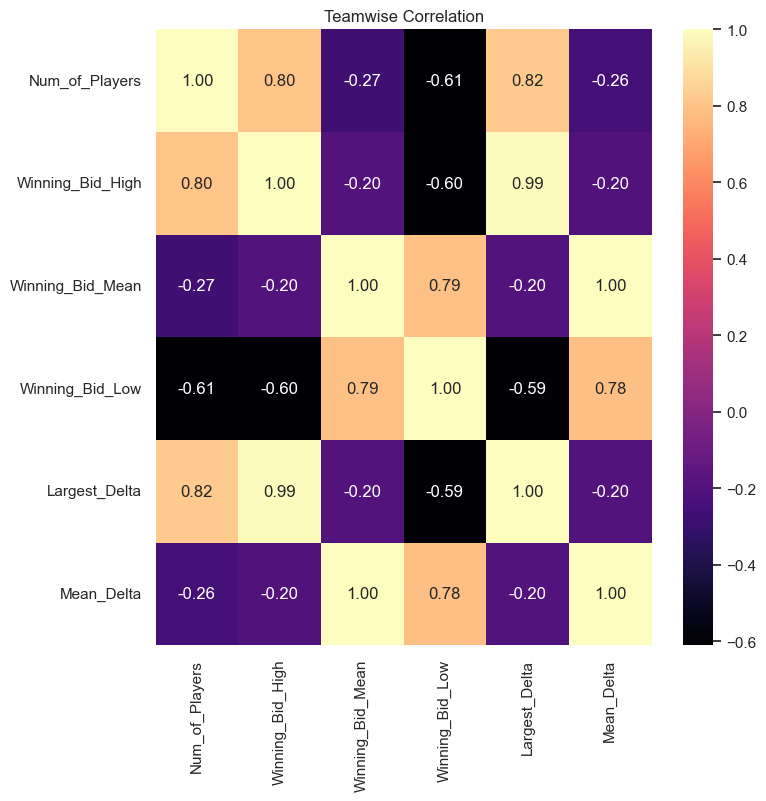

In [27]:
# Correlation Matrix for team_df
plt.figure(figsize=(8,8))
sns.heatmap(corr_team, annot=True, cmap='magma', fmt='.2f')
plt.title('Teamwise Correlation')

plt.show()

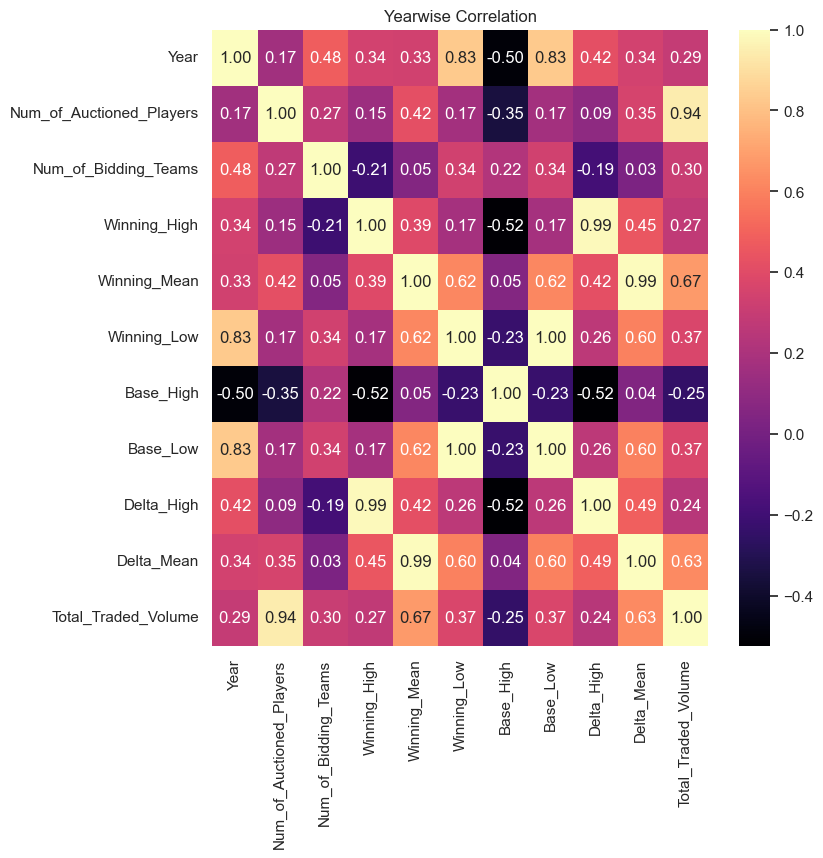

In [28]:
# Correlation Matrix for 'yearly_df'
plt.figure(figsize=(8,8))
sns.heatmap(corr_yearly, annot=True, cmap='magma', fmt='.2f')
plt.title('Yearwise Correlation')

plt.show()

#### Kruskal-Wallis & Dunn Tests

##### Kruskal Tests

In [29]:
# Winning Bid w.r.t. Country
print("Kruskal-Wallis Test Result for Winning Bid v Country")
print((lambda K: "H-statistic: " + str(K[0]) + "\np-value: " + str(K[1]))(kruskal(*[group['Winning bid'].values for _, group in df.groupby('Country')])))

Kruskal-Wallis Test Result for Winning Bid v Country
H-statistic: 141.2747406176935
p-value: 3.9573285553911046e-23


In [30]:
# Change w.r.t. Team
print("Kruskal-Wallis Test Results for Change v Team")
print((lambda K: "H-statistic: " + str(K[0]) + "\np-value: " + str(K[1]))(kruskal(*[group['Change'].values for _, group in df.groupby('Team')])))

Kruskal-Wallis Test Results for Change v Team
H-statistic: 30.338200988175434
p-value: 0.0014018730552747142


##### Heatmaps

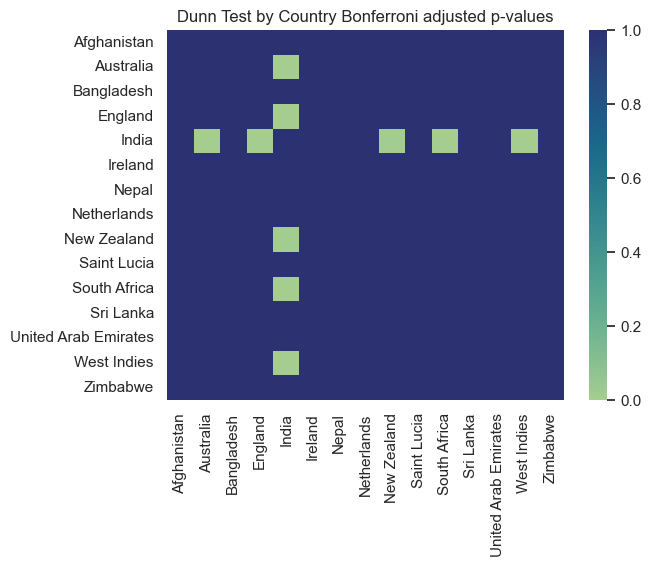

In [31]:
# Dunn Heatmap of Winning Bid w.r.t. Country
sns.heatmap(data=sp.posthoc_dunn(df, val_col='Winning bid', group_col='Country', p_adjust='bonferroni'), cmap='crest')
plt.title("Dunn Test by Country Bonferroni adjusted p-values")

plt.show();

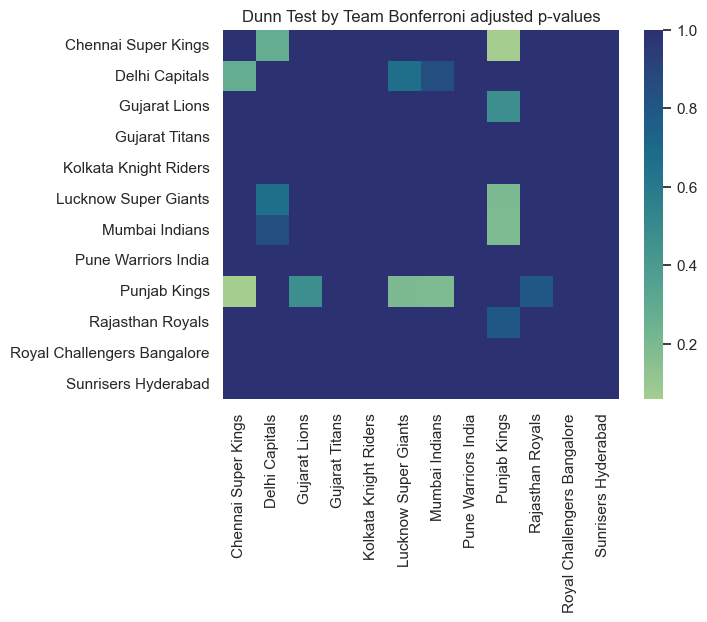

In [32]:
# Dunn Test Heatmap of Change w.r.t. Team
sns.heatmap(data=sp.posthoc_dunn(df, val_col='Change', group_col='Team', p_adjust='bonferroni'), cmap='crest')
plt.title("Dunn Test by Team Bonferroni adjusted p-values")

plt.show();

##### Boxplots

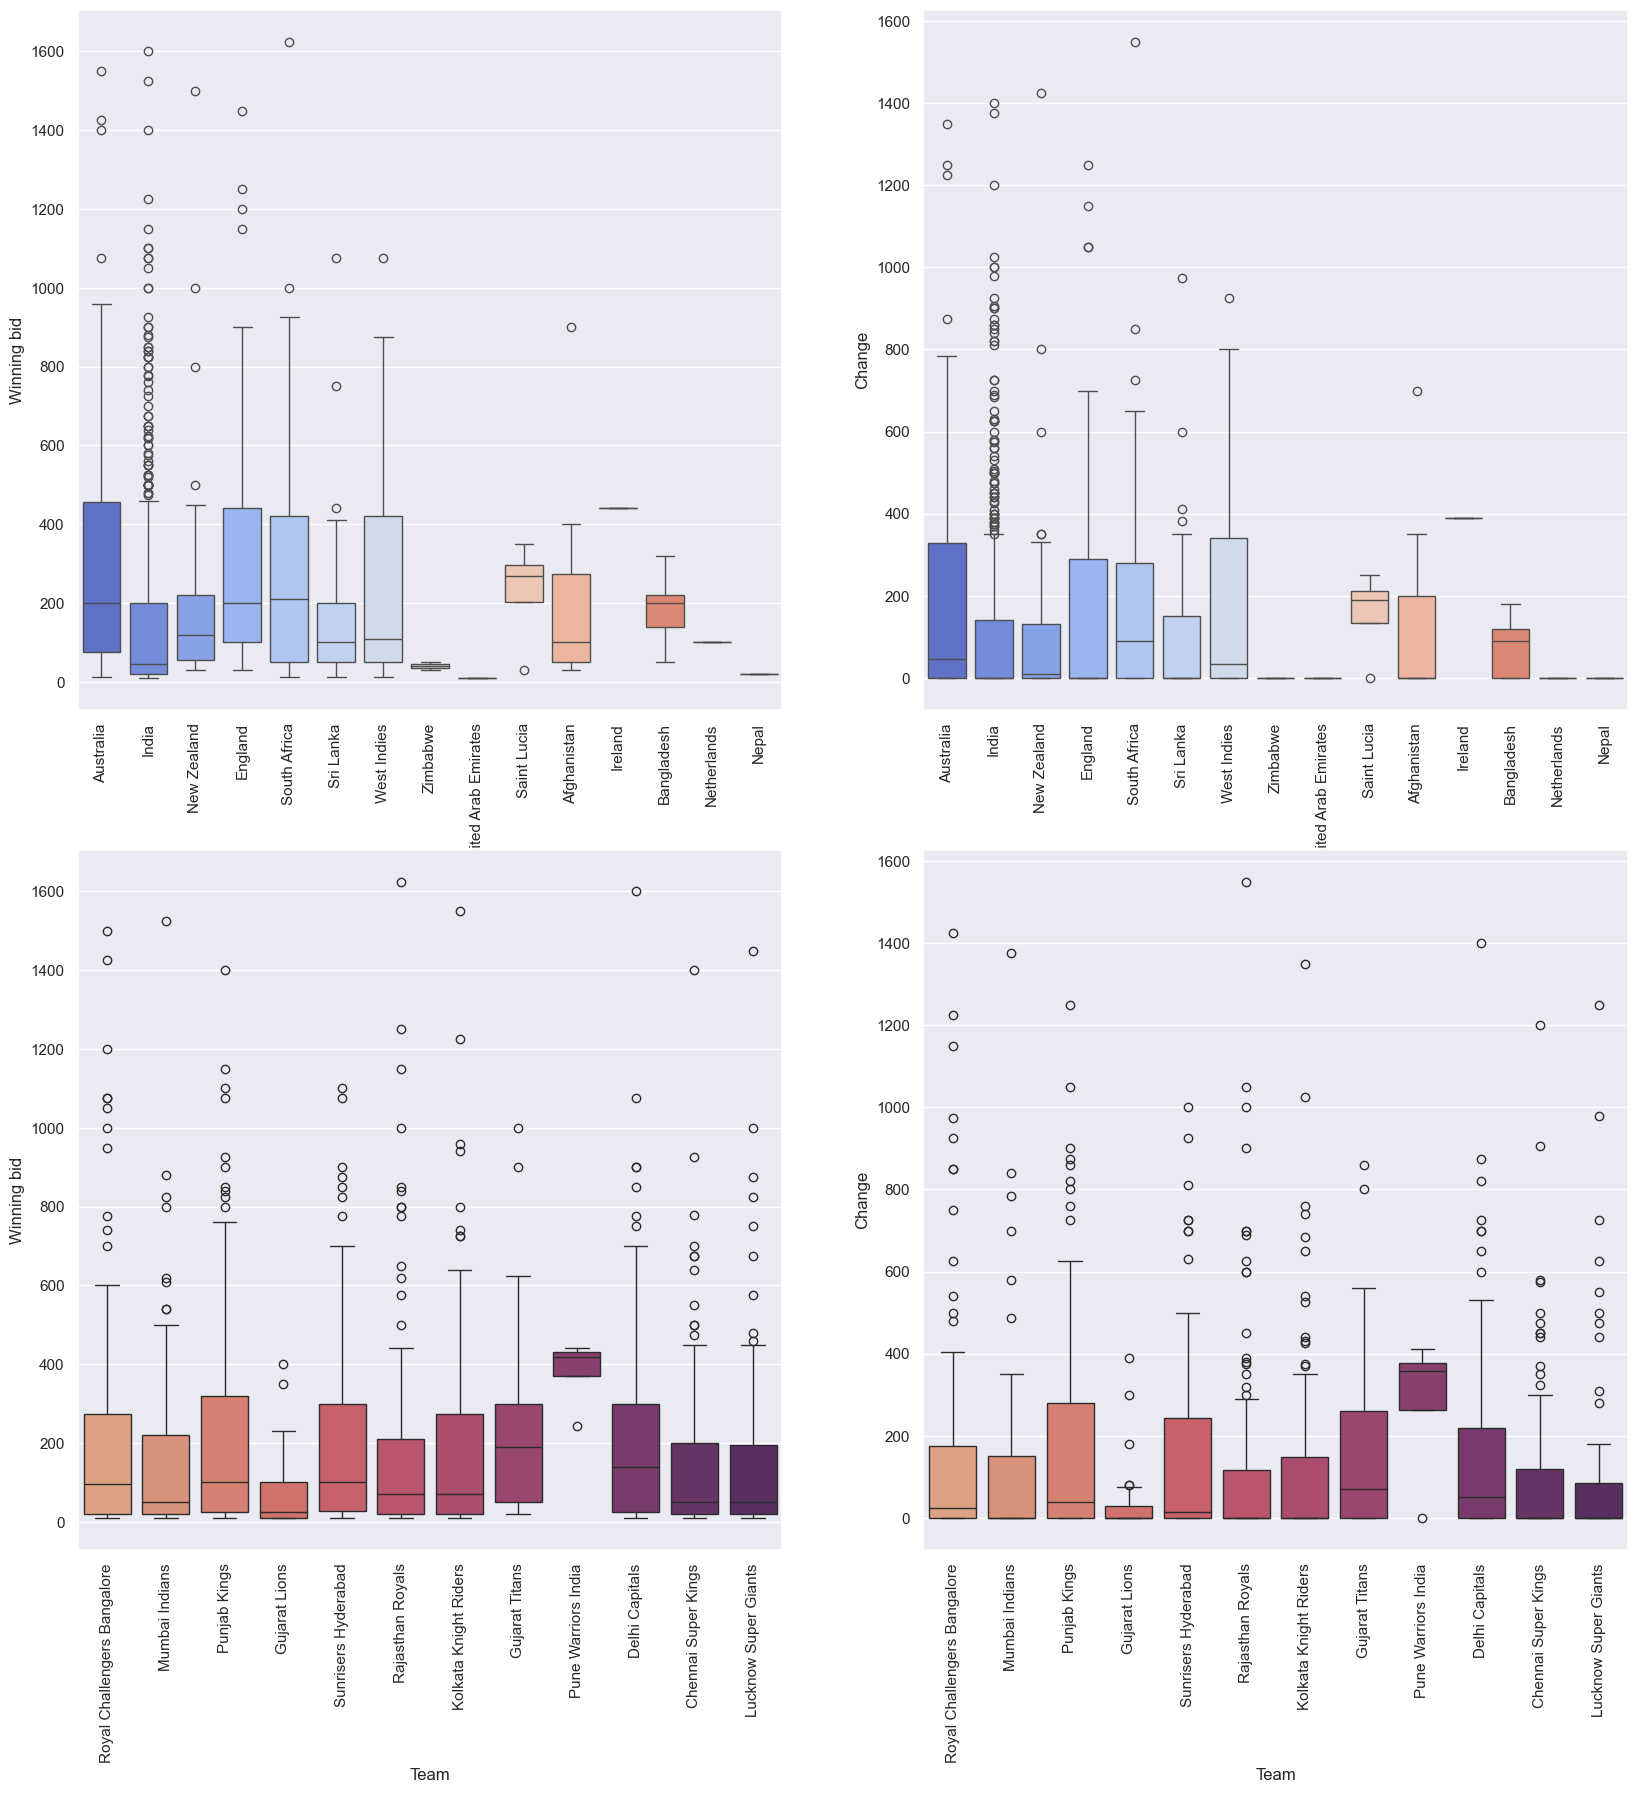

In [33]:
# Team and Country Wise Statistics
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Country', y='Winning bid', palette="coolwarm", hue="Country")
plt.xticks(rotation=90)
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Country', y='Change', palette="coolwarm", hue="Country")
plt.xticks(rotation=90)
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x="Team", y="Winning bid", palette="flare", hue="Team")
plt.xticks(rotation=90)
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x="Team", y="Change", palette="flare", hue="Team")
plt.xticks(rotation = 90)

plt.show();

#### Yearwise Statistics

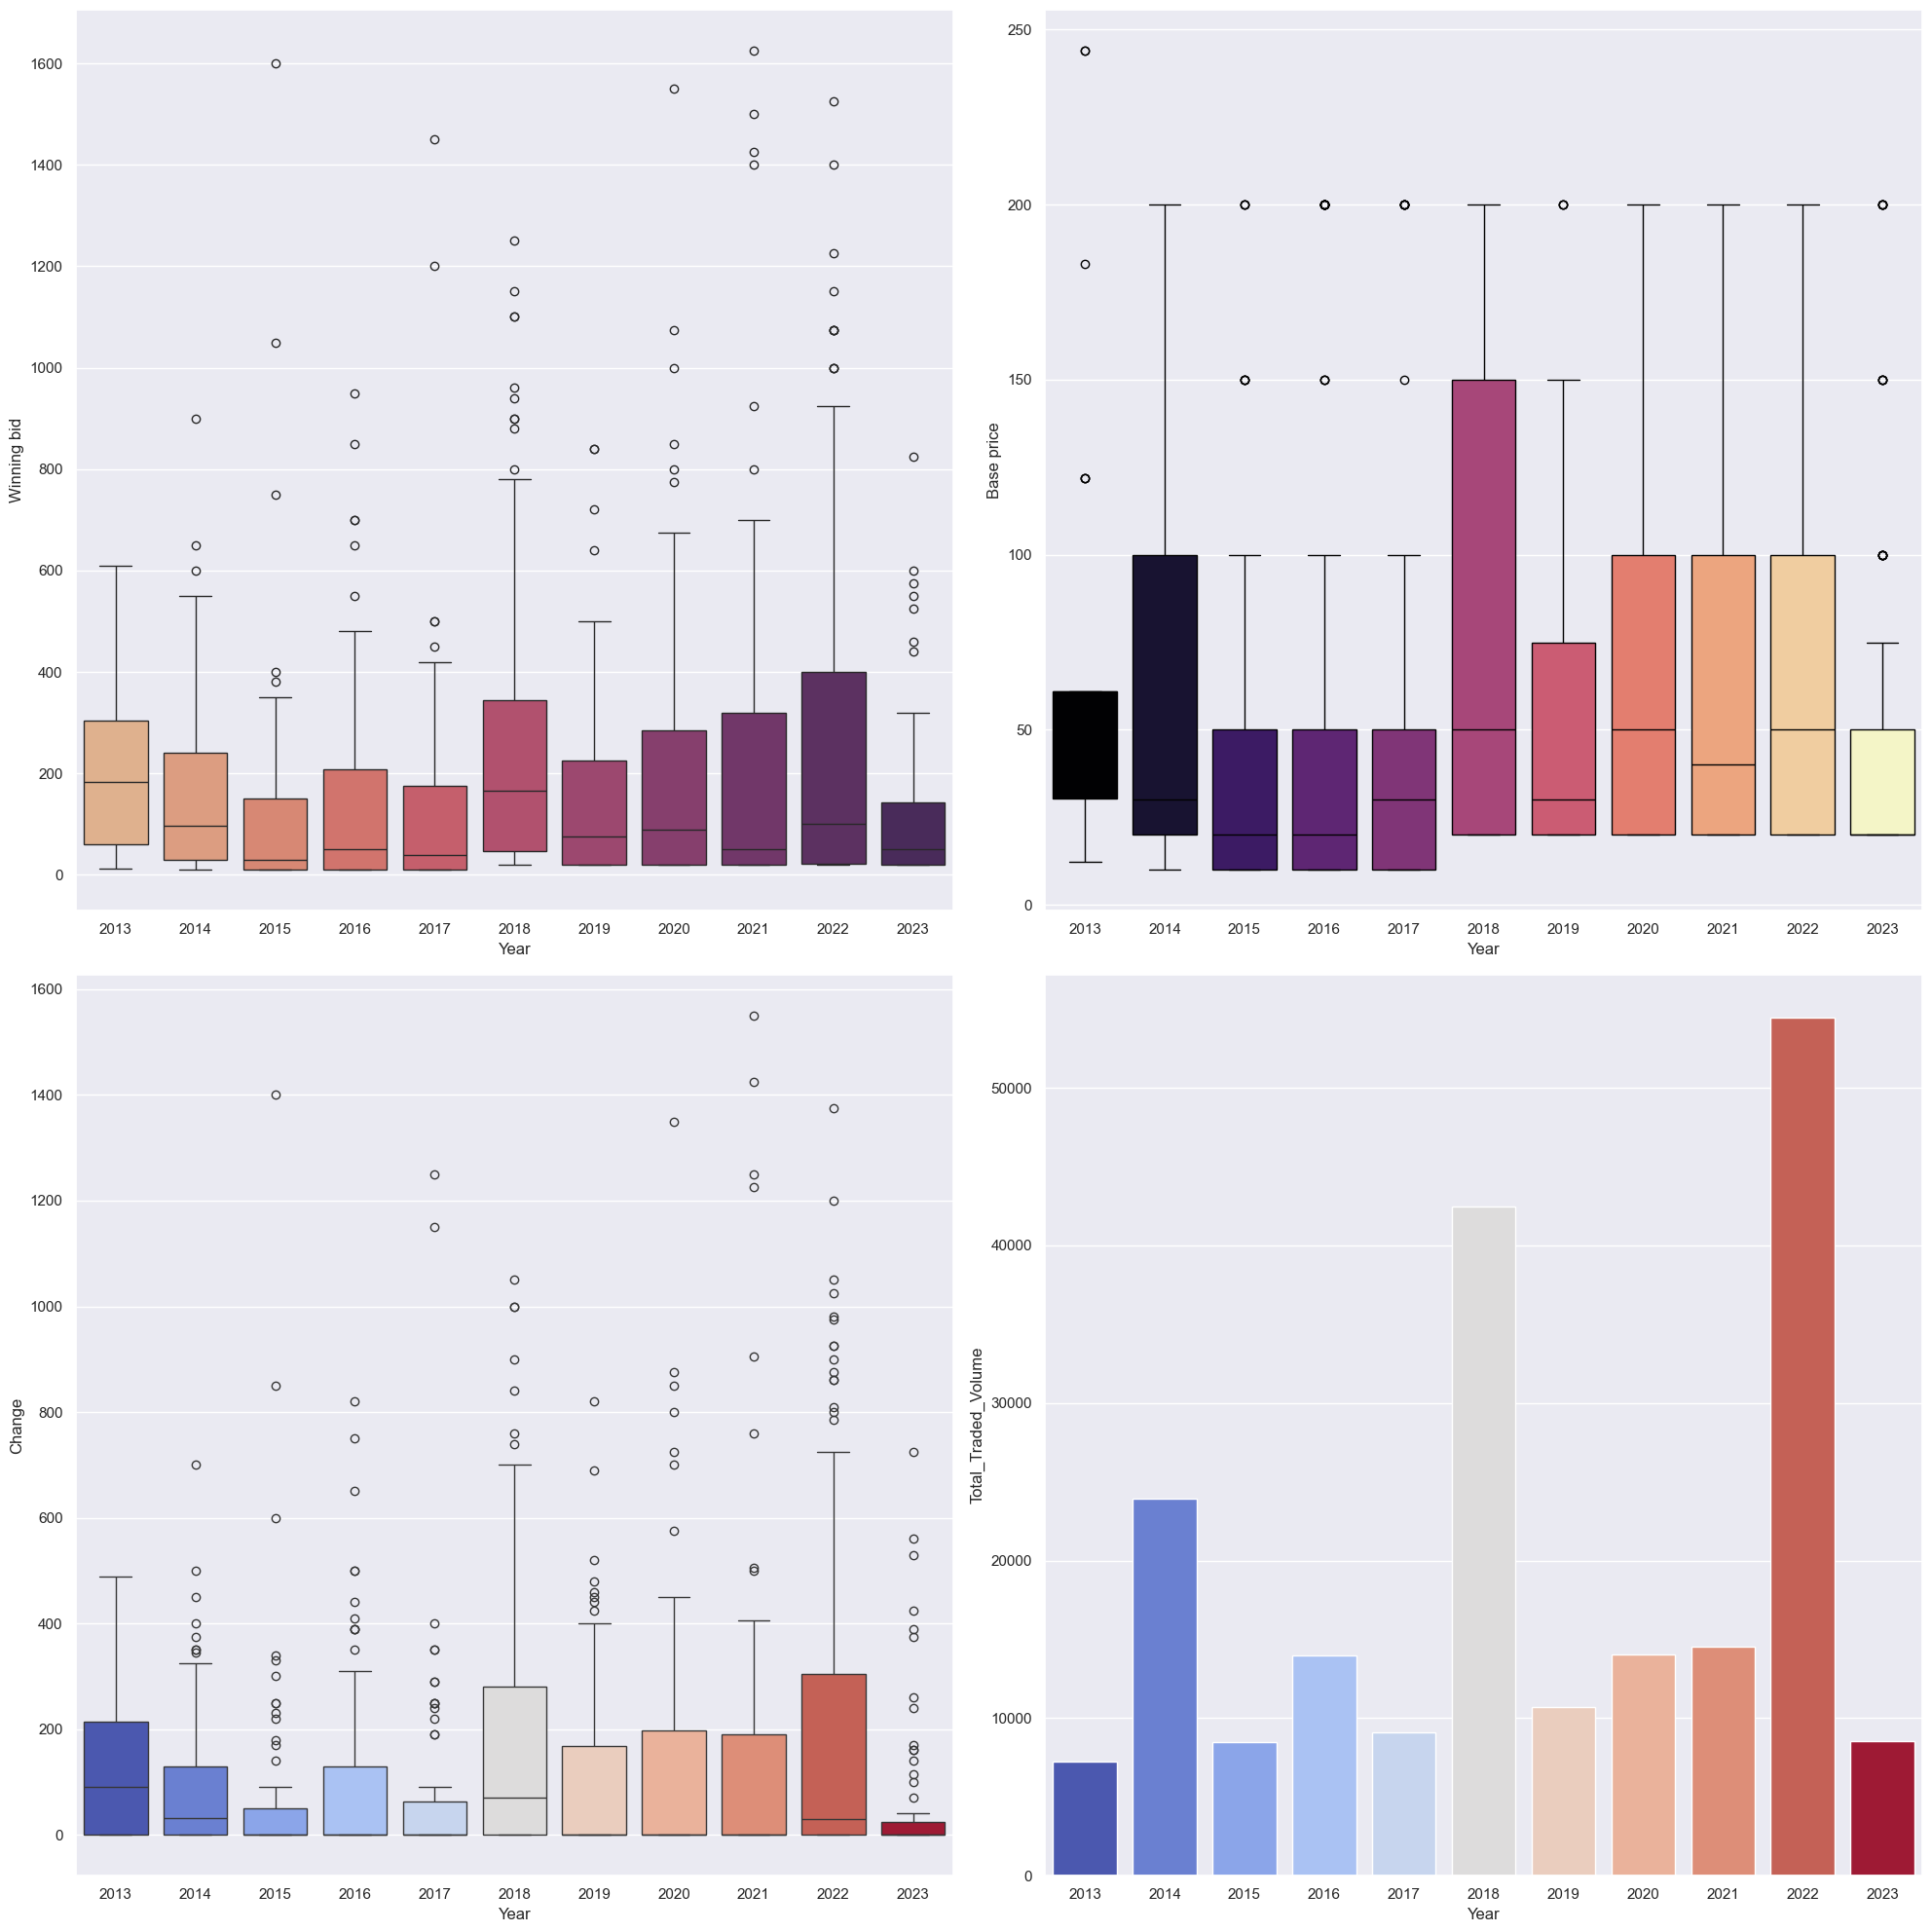

In [42]:
# Yearwise Data on Winning bid, Base Price, Change, and Total Traded Volume
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
sns.boxplot(x="Year", y="Winning bid", data=df, palette="flare", hue="Year").legend_.remove()
plt.tight_layout()
plt.subplot(2,2,2)
sns.boxplot(x="Year", y="Base price", data=df, palette="magma", hue="Year").legend_.remove()
plt.tight_layout()
plt.subplot(2,2,3)
sns.boxplot(x="Year", y="Change", data=df, palette="coolwarm", hue="Year").legend_.remove()
plt.tight_layout()
plt.subplot(2, 2, 4)
sns.barplot(x="Year", y="Total_Traded_Volume", data=yearly_df, palette="coolwarm", hue="Year").legend_.remove()
plt.tight_layout()

plt.show();

## Machine Learning

### Clustering

#### PCA + K-Means Clustering of Players

In [35]:
# PCA
pca_player_df = pd.DataFrame(
    PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
        'Base_Price_High',
        'Winning_Bid_High',
        'Winning_Bid_Mean',
        'Winning_Bid_Low',
        'Largest_Delta',
        'Mean_Delta',
        'Num_of_Teams',
        'Year_Range',
        'Avg_Trade_Gap'
    ]])),

    columns=['PC1', 'PC2']
)

pca_player_df['Player'] = player_df['Player']

In [36]:
# K-Means
pca_player_df['Cluster'] = KMeans(
    n_clusters=4,
    n_init=10,
    random_state=42
    ).fit_predict(
        PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
            'Base_Price_High',
            'Winning_Bid_High',
            'Winning_Bid_Mean',
            'Winning_Bid_Low',
            'Largest_Delta',
            'Mean_Delta',
            'Num_of_Teams',
            'Year_Range',
            'Avg_Trade_Gap'
        ]]))
    )

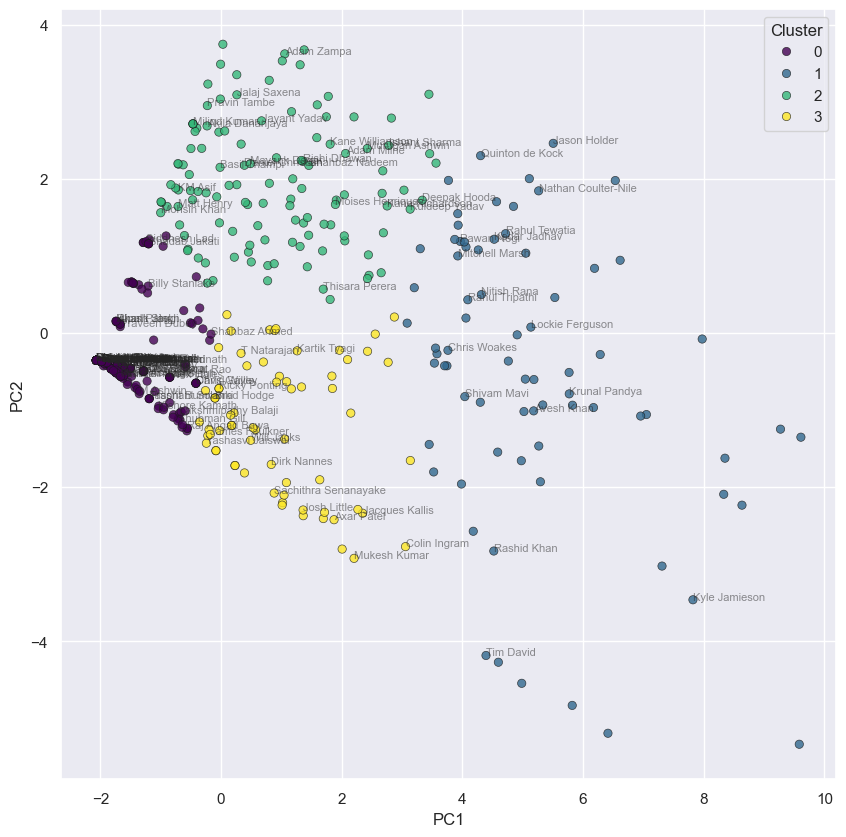

In [37]:
# PLOT
plt.figure(figsize=(10,10))

sns.scatterplot(
    x = pca_player_df['PC1'],
    y = pca_player_df['PC2'],
    hue = pca_player_df['Cluster'],
    palette = 'viridis', alpha = 0.8, edgecolor = 'k'
)

for i, player in enumerate(pca_player_df['Player']):
    if np.random.rand() < 0.2:
        plt.annotate(player, (pca_player_df['PC1'][i], pca_player_df['PC2'][i]), fontsize = 8, alpha=0.5)

In [38]:
# Metrics
print("PCA + KMC Silhouette Score: ")
print((lambda X: (sklearn.metrics.silhouette_score(X, KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
).fit_predict(X))))(
    PCA(n_components=2).fit_transform(StandardScaler().fit_transform(player_df[[
        'Base_Price_High',
        'Winning_Bid_High',
        'Winning_Bid_Mean',
        'Winning_Bid_Low',
        'Largest_Delta',
        'Mean_Delta',
        'Num_of_Teams',
        'Year_Range',
        'Avg_Trade_Gap'
    ]]))
))

PCA + KMC Silhouette Score: 
0.577804114302483


#### Dendogram for Teams

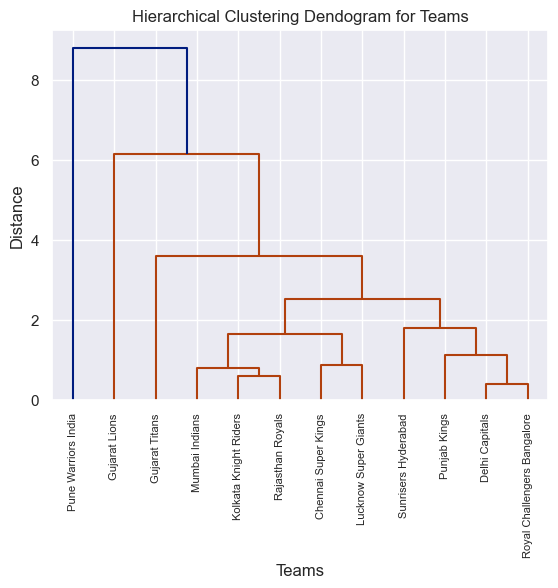

In [39]:
dendrogram(
    linkage(StandardScaler().fit_transform(
        team_df[[
            'Num_of_Players',
            'Winning_Bid_High',
            'Winning_Bid_Mean',
            'Winning_Bid_Low',
            'Largest_Delta',
            'Mean_Delta'
        ]]
    ), 
    method="ward"),

    labels=team_df['Team'].values,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.title("Hierarchical Clustering Dendogram for Teams")
plt.xlabel("Teams")
plt.ylabel("Distance")

plt.show()

### Regression

#### Linear Regression

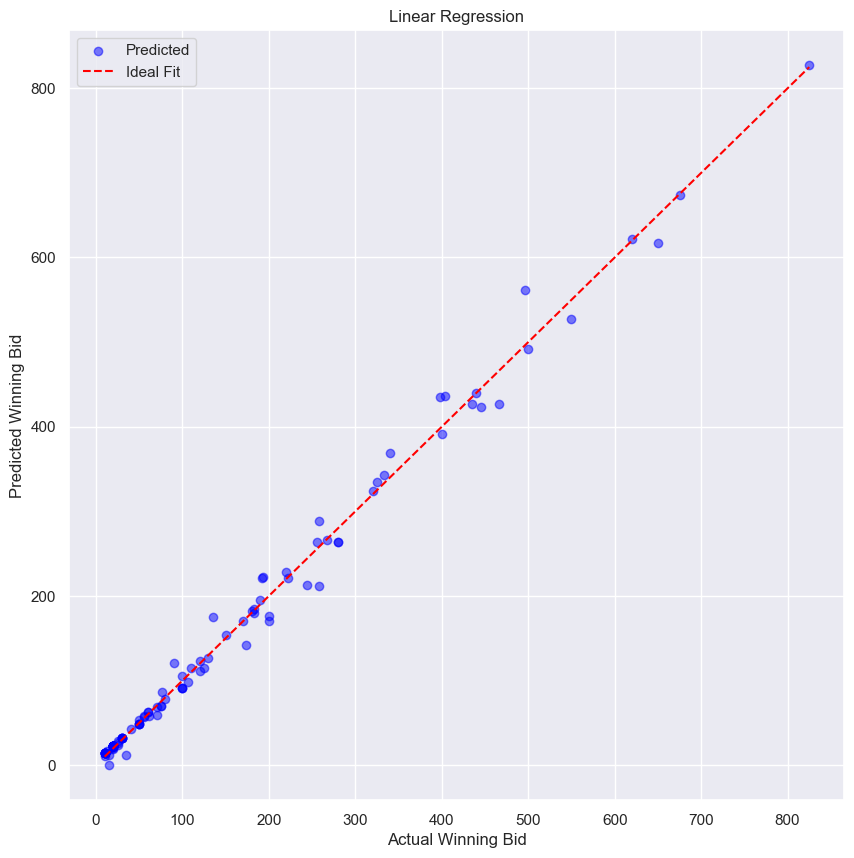

In [40]:
# Train Linear Regression Model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    player_df[[
        'Base_Price_High',
        'Num_of_Teams',
        'Largest_Delta',
        'Mean_Delta',
        'Year_Range',
        'Avg_Trade_Gap'
    ]],

    player_df[[
        'Winning_Bid_Mean'
    ]],

    test_size=0.2, random_state=42
)

model = sklearn.linear_model.LinearRegression().fit(X_train, Y_train)

Y_pred = model.predict(X_test)

plt.figure(figsize=(10,10))

plt.scatter(Y_test, Y_pred, alpha=0.5, color='blue', label="Predicted")
plt.plot(
    [Y_test.min(), Y_test.max()],
    [Y_test.min(), Y_test.max()],
    
    color = 'red', linestyle = '--', label = 'Ideal Fit'
)

plt.xlabel("Actual Winning Bid")
plt.ylabel("Predicted Winning Bid")
plt.title("Linear Regression")
plt.legend()

plt.show()

In [41]:
# Metrics
print("Linear R² Score: ")
print(sklearn.metrics.r2_score(Y_test, Y_pred))

print("Linear RMSE: ")
print(sklearn.metrics.root_mean_squared_error(Y_test, Y_pred))

Linear R² Score: 
0.9926190390390234
Linear RMSE: 
14.599552224327878
